### Classifying healthy people and diabetic people based on their body measurements and body compositions

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import ExcelWriter
from pandas import ExcelFile

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


In [12]:
address='DataSet/NHANES 1999-2006.xlsx'
df=pd.read_excel(address)

In [13]:
#Feature extraction (Research)
feature_dem=['RIAGENDR','RIDAGEYR','RACETH']
feature_bc=['DXDTOFAT','DXDTOLE','DXXTRFAT','DXXLAFAT','DXXLLFAT',]
feature_cal=['DRXTKCAL','DRXTCARB','DRXTPROT','DRXTTFAT','DRXTSFAT']
feature_BM=['bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR','BMXARMC','BMXLEG','BMXCALF','BMXARML']
feature_diab=['DIQ050','DIQ070','MCQ250A']
feature_bp=['BPQ020']
feature_act=['PAD020','PAD080','PAQ100','PAD120','PAD160','PAQ180','PAQ480','PAD200','PAD320','PAD440','PAQ050Q','PAQ050U','PAQ540','PAQ500','PAQ520']
feature_sm=['SMQ020','SMQ040']
feature_ed=['DMDEDUC2','DMDHHSIZ','INDFMINC','INDFMPIR']
target=['lbxglu']
feature_preg=['RIDEXPRG']

feature_tot=target+feature_dem+ feature_cal+feature_BM+feature_diab+feature_bp+feature_act+feature_sm+feature_ed+feature_preg+feature_bc

df_diab=df[feature_tot]
df_diab.shape

(29026, 49)

In [14]:
#Defining Diabetes/Pre-Diabetes and healthy classes

df_diab=df_diab.dropna(subset=['lbxglu'])
print(df_diab.shape)
df_diab['Diabetic']= df_diab['lbxglu'].apply(lambda x: 1 if (x>100)  else 0) # defining two classes in Diabetic column
#df_diab.isnull().sum()
#df_diab1= outliers_IQR2(df_diab)
#df_diab1.shape

(12037, 49)


In [15]:
# considering only subject that are not taking insulin or pills because it affects their 

#df_diab['DIQ070']=df_diab['DIQ070'].fillna(0)
#df_diab['DIQ050']=df_diab['DIQ050'].fillna(0)

df_diab=df_diab.loc[(df_diab['DIQ070']!=1 )&(df_diab['DIQ050']!=1)]  
df_diab=df_diab.drop(columns=['DIQ070', 'DIQ050'])
print(df_diab.shape)


(11374, 48)


In [16]:
df_diab.isnull().sum()
df_diab['MCQ250A']=df_diab['MCQ250A'].fillna(2) #If no input --> No family history
df_diab['BPQ020']=df_diab['BPQ020'].fillna(2) #If no input --> No blood pressure history
df_diab.groupby(['BPQ020']).size()
#df_diab.isnull().sum()

BPQ020
1.0    2226
2.0    9148
dtype: int64

[[3.         2.03349808]
 [2.         2.03349808]
 [2.         1.        ]
 ...
 [2.55379119 2.        ]
 [2.55379119 2.03349808]
 [2.55379119 2.03349808]]


In [103]:
#Function for removing outliers

def outliers_IQR2(data,fs, t=3):
    threshold = t
    Q1 = data[fs].quantile(0.25)
    Q3 = data[fs].quantile(0.75)
    IQR = Q3 - Q1
    
    dataf=data[~((data[fs] <(Q1 - threshold * IQR)) | (data[fs] > (Q3 + threshold * IQR)))]
    return dataf

In [92]:
#Imputations

df_diab['MCQ250A']=df_diab['MCQ250A'].fillna(0)
df_diab['BPQ020']=df_diab['BPQ020'].fillna(2)
df_diab['PAQ480']=df_diab['PAQ480'].fillna(8)
df_diab['PAQ050U']=df_diab['PAQ050U'].fillna(0)
df_diab['PAQ050Q']=df_diab['PAQ050Q'].fillna(0)
df_diab['SMQ020']=df_diab['SMQ020'].fillna(2)
df_diab['PAQ540']=df_diab['PAQ540'].fillna(3)
df_diab['PAQ500']=df_diab['PAQ500'].fillna(3)
df_diab['PAQ520']=df_diab['PAQ520'].fillna(3)

df_diab.loc[df_diab['SMQ020']==2 , ['SMQ040']]=3;  #non-smoker

df_diab2=df_diab.loc[df_diab['DIQ070']!=1 ]  # considering only subject that are not taking insulin or pills
df_diab2=df_diab2.loc[df_diab2['DIQ050']!=1]
df_diab2.shape

(11374, 48)

In [93]:
#Feature engineering for activity level (making new features)

df_diab2.loc[df_diab2['PAD020']!=1 , ['PAD080']]=0;  
df_diab2.loc[df_diab2['PAQ100']!=1 , ['PAD120']]=0;
df_diab2.loc[df_diab2['PAQ100']!=1 , ['PAD160']]=0;

#df_diab2['Act'] : daily activity (hour)
df_diab2['W']=1 #defult is daily
df_diab2.loc[df_diab2['PAQ050U']==1 , ['W']]=1;
df_diab2.loc[df_diab2['PAQ050U']==2 , ['W']]=7;
df_diab2.loc[df_diab2['PAQ050U']==3 , ['W']]=30;

df_diab2['Act']=(((df_diab2['PAD080']*df_diab2['PAQ050Q']/df_diab2['W'])+(df_diab2['PAD120']*df_diab2['PAD160']/30)))
#df_diab2['Act']=(df_diab2['PAD080'])/60

df_diab2['Act_level']=0
df_diab2.loc[df_diab2['Act']<=10 , ['Act_level']]=0;
df_diab2.loc[(df_diab2['Act']<=60) & (df_diab2['Act']>10), ['Act_level']]=1;
df_diab2.loc[(df_diab2['Act']>60), ['Act_level']]=2;

(11352, 51)


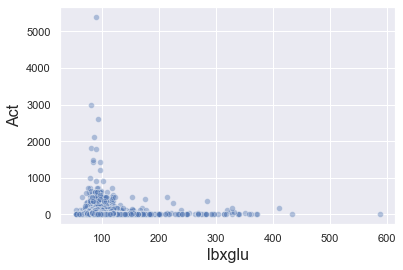

In [94]:
df_diab2=df_diab2.dropna(subset=['Act'])
print(df_diab2.shape)
#sns.distplot(df_diab3.Act , color="olive")
ax =sns.scatterplot(x="lbxglu", y="Act", data=df_diab2,alpha=0.4)
#ax =sns.barplot(x="RIDEXPRG", y="Diabetic", data=df_diab2,alpha=0.4)

In [8]:
df_diab2.isnull().sum()


NameError: name 'df_diab2' is not defined

In [96]:

# feature_tot2=['lbxglu','RIAGENDR','RIDAGEYR','RACETH','DXDTOFAT','DXDTOLE','DRXTKCAL','DRXTCARB','DRXTPROT','DRXTTFAT',
#  'DRXTSFAT','DXXTRFAT','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
#  'BMXARMC','BMXLEG','BMXCALF','BMXARML',
#  'MCQ250A','BPQ020','Act','PAQ180',
#  'PAQ480','SMQ020','SMQ040']

# feature_tot3=['lbxglu','RIAGENDR','RIDAGEYR','RACETH','DXDTOFAT','DXDTOLE','DRXTKCAL','DRXTCARB','DRXTPROT','DRXTTFAT',
#  'DRXTSFAT','DXXTRFAT','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
#  'BMXARMC','BMXLEG','BMXCALF','BMXARML','MCQ250A','BPQ020','Act','SMQ020','SMQ040','PAQ180','PAQ480','DMDEDUC2','DMDHHSIZ','INDFMINC']

feature_cont=['lbxglu','RIDAGEYR','DRXTKCAL','DRXTCARB','DRXTPROT','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
              'BMXARMC','BMXLEG','BMXCALF','BMXARML','Act']
feature_cat=['RIAGENDR','RACETH','MCQ250A','BPQ020','SMQ020','SMQ040',
             'PAQ180','PAQ480','PAQ540','PAQ500','PAQ520','DMDEDUC2','DMDHHSIZ','INDFMINC','Act_level','Diabetic']
df_diab3=df_diab2[feature_cat+feature_cont+feature_bc]

#df_diab3['pro_car']=df_diab3['DRXTPROT']/df_diab3['DRXTCARB']
df_diab3['Inact']=df_diab3['PAQ480'].apply(lambda x: 1 if (6>x>=3)  else 0) #more than 3 hours TV: inactive=1
df_diab3['gen_act']=df_diab3['PAQ180'].apply(lambda x: 1 if (x>1)  else 0)  #low physical activity: gen_act=0
# df_diab3['Bl_pres']=df_diab3['BPQ020'].apply(lambda x: 1 if (x==1)  else 0)
df_diab3['Fa_hist']=df_diab3['MCQ250A'].apply(lambda x: 1 if (x==1)  else 0)
df_diab3['Educ']=df_diab3['DMDEDUC2'].apply(lambda x: 1 if (x>=2)  else 0) #Not having Diploma: Educ=0
df_diab3['HHS']=df_diab3['DMDHHSIZ'].apply(lambda x: 1 if (x>=3)  else 0) #houshold size more than 2: HHS=1

df_diab3.shape

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

(11352, 39)

In [97]:
print(df_diab3.shape)
df_diab3=df_diab3.dropna()
print(df_diab3.shape)


(11352, 39)
(8283, 39)


In [98]:
#df_diab4.gen_act.value_counts()
df_diab3.groupby(['Diabetic']).size()
df_diab4=df_diab3

In [334]:
#pd.plotting.scatter_matrix(df_diab4, figsize=(6, 6))

In [312]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
X_cat=df_diab4[feature_cat]
Y_cat=df_diab4['Diabetic']

def prepare_inputs(X_train, X_test):
    oe=OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc=oe.transform(X_train)
    X_test_enc=oe.transform(X_test)
    return X_train_enc, X_test_enc



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user

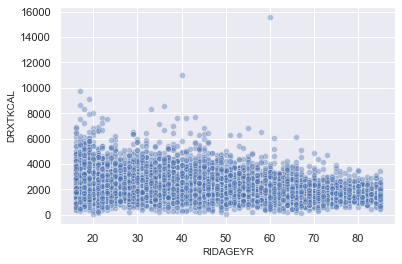

In [160]:
#ax =sns.barplot(x="Diabetic", y="DXXTRFAT", data=df_diab4,alpha=1)

import math
df_diab5= outliers_IQR2(df_diab4,'lbxglu')
#df_diab5=df_diab4
df_diab5['fat_ratio']=df_diab5['DXXTRFAT']/df_diab5['DXDTOFAT']
df_diab5['fat_per']=df_diab5['DXDTOFAT']/df_diab5['bmxwt']
df_diab5['WCI']=df_diab5['bmxwaist']/(df_diab5['bmxht'].apply(np.sqrt))
df_diab5['Cal_age']=df_diab5['DRXTKCAL']*(df_diab5['RIDAGEYR']/20)


ax =sns.scatterplot(x="RIDAGEYR", y="DRXTKCAL", data=df_diab5,alpha=0.4)

DMDEDUC2
1.0    1040
2.0    2260
3.0    2005
4.0    2160
5.0    1381
dtype: int64

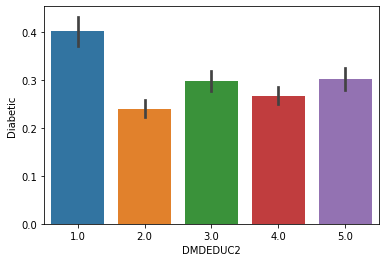

In [33]:
ax =sns.barplot(x="DMDEDUC2", y="Diabetic", data=df_diab4,alpha=1)
df_diab3.groupby(['DMDEDUC2']).size()

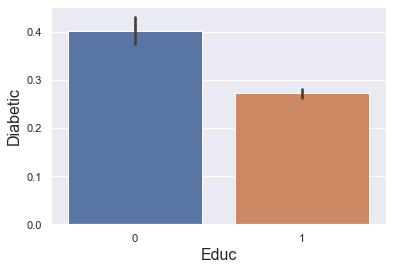

In [484]:
ax =sns.barplot(x="Educ", y="Diabetic", data=df_diab4,alpha=1)

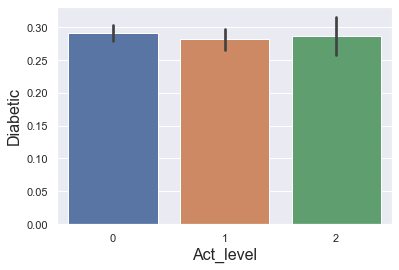

In [483]:
ax =sns.barplot(x="Act_level", y="Diabetic", data=df_diab4,alpha=1)

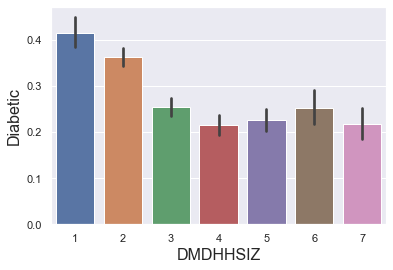

In [481]:
ax =sns.barplot(x="DMDHHSIZ", y="Diabetic", data=df_diab4,alpha=1)

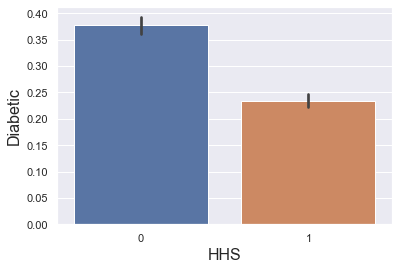

In [482]:
ax =sns.barplot(x="HHS", y="Diabetic", data=df_diab4,alpha=1)

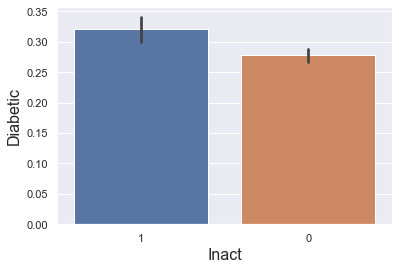

In [509]:
#df_diab3.head()
#sns.distplot(df_diab3.DRXTPROT , color="olive")
ax =sns.barplot(x="Inact", y="Diabetic",order=[1, 0], data=df_diab4,alpha=1)
#ax =sns.scatterplot(x="lbxglu", y="DRXTPROT", data=df_diab4,alpha=0.4)

PAQ480
0.0     529
1.0     750
2.0    1205
3.0     883
4.0     509
5.0     708
6.0      57
8.0    4205
dtype: int64

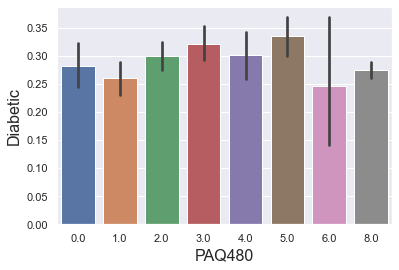

In [507]:
ax =sns.barplot(x="PAQ480", y="Diabetic", data=df_diab4,alpha=1)
df_diab3.groupby(['PAQ480']).size()

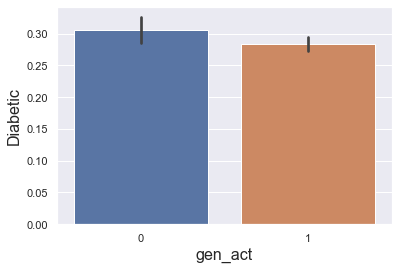

In [508]:
ax =sns.barplot(x="gen_act", y="Diabetic", data=df_diab4,alpha=1)

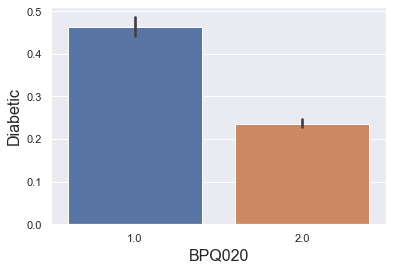

In [488]:
ax =sns.barplot(x="BPQ020", y="Diabetic", data=df_diab4,alpha=1)

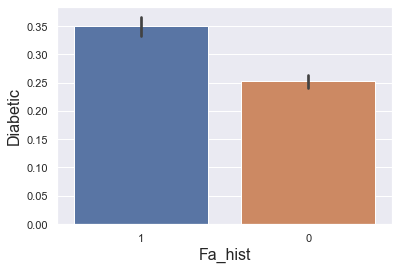

In [502]:
ax =sns.barplot(x="Fa_hist", y="Diabetic",order=[1, 0], data=df_diab4,alpha=1)

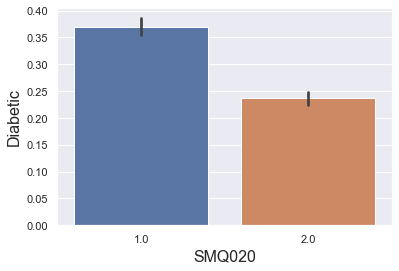

In [490]:
ax =sns.barplot(x="SMQ020", y="Diabetic", data=df_diab4,alpha=1)

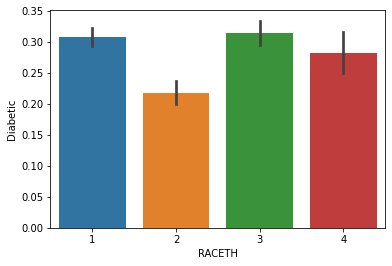

In [367]:
ax =sns.barplot(x="RACETH", y="Diabetic", data=df_diab4,alpha=1)

Diabetic  PAQ520
0         1.0       2216
          2.0       1202
          3.0       2880
1         1.0        971
          2.0        476
          3.0       1101
dtype: int64

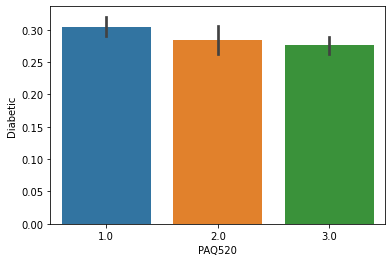

In [32]:
ax =sns.barplot(x="PAQ520", y="Diabetic", data=df_diab4,alpha=1)
df_diab3.groupby(['Diabetic','PAQ520']).size()

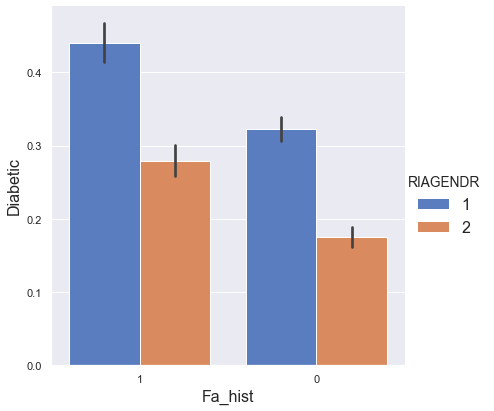

In [501]:
g = sns.catplot(x="Fa_hist", y="Diabetic", hue="RIAGENDR",order=[1, 0], data=df_diab4,
                height=6, kind="bar", palette="muted")

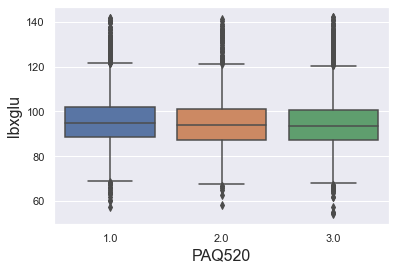

In [479]:
df_diab5= outliers_IQR2(df_diab4,'lbxglu')
sns.boxplot(x="PAQ520", y="lbxglu", data=df_diab5)

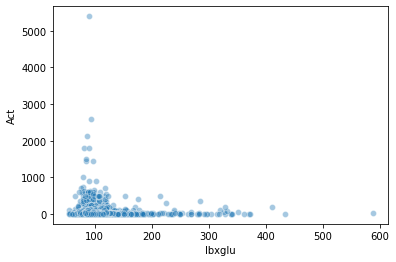

In [368]:
#sns.distplot(df_diab3.Act , color="olive")
ax =sns.scatterplot(x="lbxglu", y="Act", data=df_diab4,alpha=0.4)
#ax =sns.barplot(x="Diabetic", y="Act", data=df_diab4,alpha=0.4)

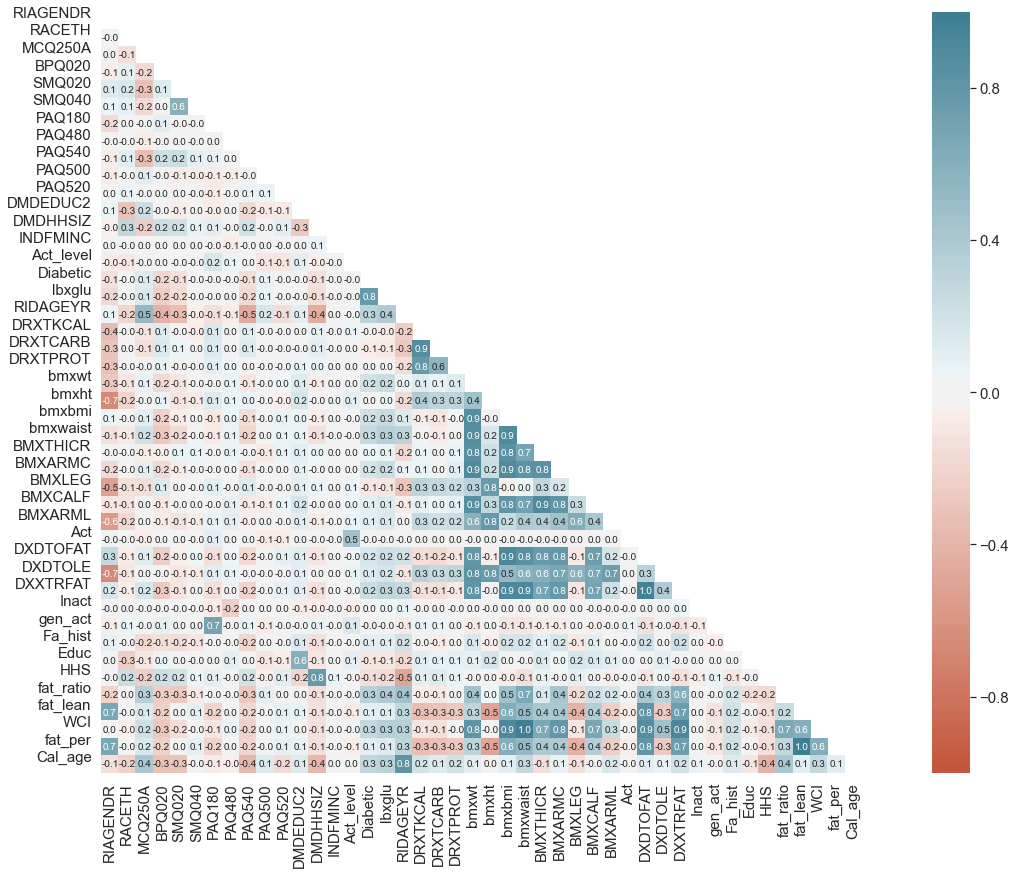

In [157]:
corr=df_diab5.corr()  # Drawing correlation heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(25, 14))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, 
    cmap=sns.diverging_palette(20, 220, n=200), square=True,annot = True,fmt='1.1f')
    rc={'axes.labelsize': 10, 'font.size': 10, 'legend.fontsize': 10, 'axes.titlesize': 10}
    sns.set(rc=rc)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=15)

    ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    horizontalalignment='right',
    verticalalignment='bottom',
    fontsize=15      
);
    ax.set_xticklabels(
    ax.get_xticklabels(),
    
    fontsize=15     
);

In [370]:
# diabetic group data
mask_diab_1=df_diab4.Diabetic==1
df_diab_1=df_diab4[mask_diab_1]
# Healthy group data
mask_diab_0=df_diab4.Diabetic==0
df_diab_0=df_diab4[mask_diab_0]

#### Here I am running some initial visualization to learn about the data distribution.For instance ploting histogram of "total body fat" for two genders, shows that as the total fat increases ratio of diabetic people (class 1) to healthy people (class 0) increases. Also it shows that there are more diabetics among females(gender=1)compared to the males (gender=2).
#### Initial analysis like this can give us more insight for feature selection, finding the outliers and model selection.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


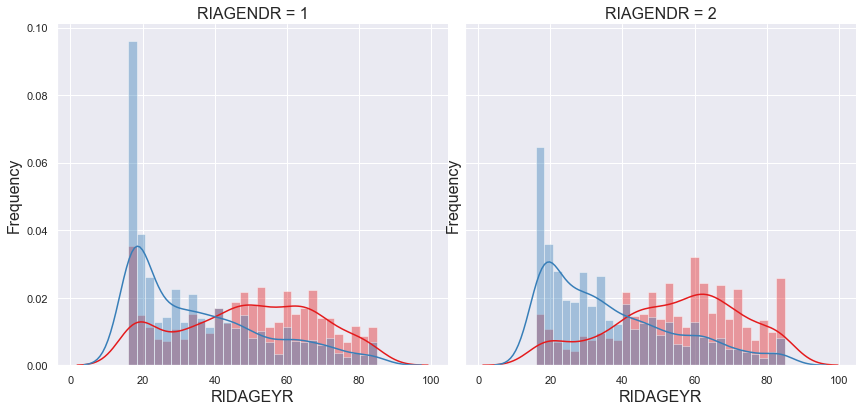

In [51]:
#Exploring the normalized distribution of diabetic and healthy people based on their total fat mass and gender 
from scipy import stats

bins = np.linspace(df_diab4.RIDAGEYR.min(), df_diab4.RIDAGEYR.max(), 30)
g = sns.FacetGrid(df_diab3, col="RIAGENDR", hue="Diabetic",hue_order=[1,0], palette="Set1", col_wrap=2,size=6)
g.map(sns.distplot, 'RIDAGEYR', bins=bins)
g.set(xlabel = 'RIDAGEYR', ylabel = 'Frequency')
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 16, 'axes.titlesize': 18}
sns.set(rc=rc)
#g.axes[-1].legend()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


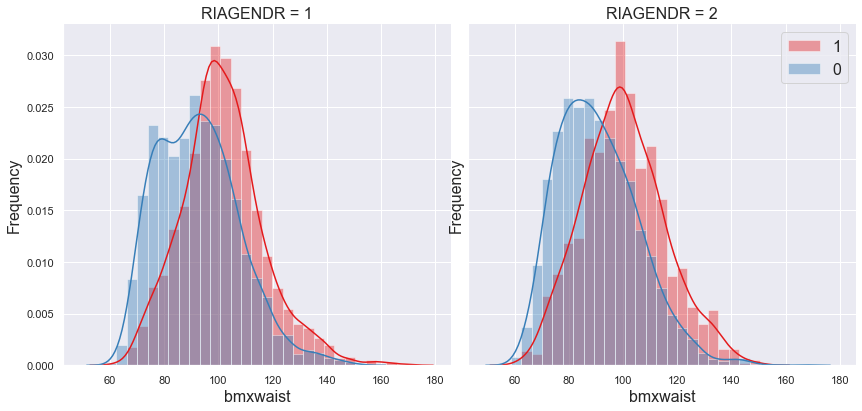

In [48]:
#Exploring the normalized distribution of diabetic and healthy people based on their total fat mass and gender 
from scipy import stats

bins = np.linspace(df_diab4.bmxwaist.min(), df_diab4.bmxwaist.max(), 30)
g = sns.FacetGrid(df_diab3, col="RIAGENDR", hue="Diabetic",hue_order=[1,0], palette="Set1", col_wrap=2,size=6)
g.map(sns.distplot, 'bmxwaist', bins=bins)
g.set(xlabel = 'bmxwaist', ylabel = 'Frequency')
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 16, 'axes.titlesize': 18}
sns.set(rc=rc)
g.axes[-1].legend()
plt.show()

#### Distribution of Total Fat in diabetic males and females is different from non-diabetic males and females. 

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


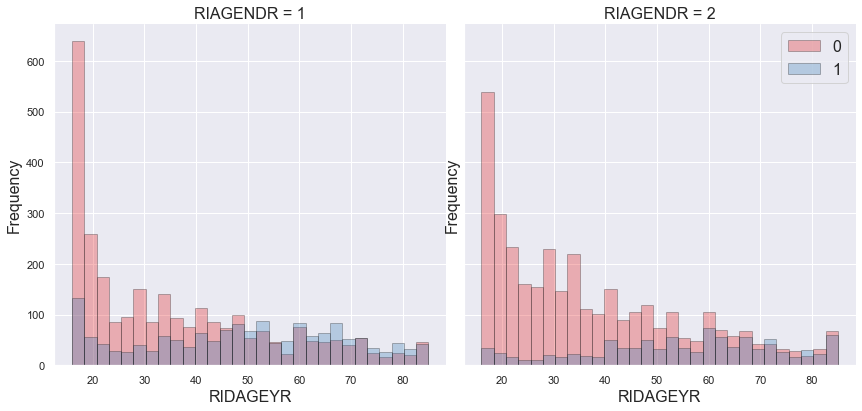

In [375]:
#Exploring the distribution of diabetic and healthy people based on their total fat mass and gender 

bins = np.linspace(df_diab4.RIDAGEYR.min(), df_diab4.RIDAGEYR.max(), 30)
g = sns.FacetGrid(df_diab4, col="RIAGENDR", hue="Diabetic", palette="Set1", col_wrap=2,size=6)
g.map(plt.hist, 'RIDAGEYR', bins=bins, ec="k",alpha=0.3)
g.set(xlabel = 'RIDAGEYR', ylabel = 'Frequency')
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 16, 'axes.titlesize': 18}
sns.set(rc=rc)
g.axes[-1].legend()
plt.show()

In [383]:
df_diab3.groupby(['Diabetic','RIAGENDR']).size()

Diabetic  RIAGENDR
0         1           2798
          2           3500
1         1           1577
          2            971
dtype: int64

In [376]:
from scipy.stats import ttest_ind

def LR(Data,feat_list,target):
    
    feat_reg=feat_list.copy()
    #feat_reg.remove('BC_DXA_FAT_TOT')
    #feat_reg.remove('BC_DXA_LST_TOT')
    #feat_reg.remove('DEM_SEX')
    
    X=Data[feat_reg]
    y=Data[target]
    X= preprocessing.StandardScaler().fit(X).transform(X)
    clf = LinearRegression()
    scores = cross_validate(clf, X, y, cv=5,return_train_score=True,return_estimator=True)
    y_hat=cross_val_predict(clf, X, y, cv=5)
    
    print('Linear regression model:')
    print("Train Accuracy: %0.3f +/- %0.3f" % (scores['train_score'].mean(), scores['train_score'].std() ))
    print("Test Accuracy: %0.3f +/- %0.3f" % (scores['test_score'].mean(), scores['test_score'].std() ))
    
    print(cross_val_score(clf, X, y, cv=5))

    fig, ax = plt.subplots()
    ax.scatter(y, y_hat, edgecolors=(0, 0, 1))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    
    return

In [377]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

def RF(Data,feat_list,target):
    
    feat_reg=feat_list.copy()

    X=Data[feat_reg]
    y=Data[target]
    X= preprocessing.StandardScaler().fit(X).transform(X)
    #X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
    
    regr = RandomForestRegressor(max_depth=3, random_state=0)
    regr.fit(X, y)

    clf = LinearRegression()
    y_hat=regr.predict(X)
    
    #print(cross_val_score(clf, X, y, cv=5))

    fig, ax = plt.subplots()
    ax.scatter(y, y_hat, edgecolors=(0, 0, 1))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    
    return

###  Machine learning models (Logistic regression, Random forest, SVM, Naive Bayes ) are appleid for this classification problem

In [136]:
#Splitting the data in test (20%) and train(80%) sets 
from sklearn.model_selection import train_test_split

FS3=['RIAGENDR','RIDAGEYR','RACETH','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
 'BMXARMC','BMXLEG','BMXCALF','BMXARML','Inact','gen_act','Act','SMQ020','Bl_pres','Fa_hist','Educ',"HHS"]
FS3=['RIAGENDR','RIDAGEYR','RACETH','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
 'BMXARMC','BMXLEG','BMXCALF','BMXARML','Inact','gen_act','Act','SMQ020','Bl_pres','Fa_hist','DMDEDUC2',"DMDHHSIZ"]

feature_cont=['RIDAGEYR','DRXTKCAL','DRXTCARB','DRXTPROT','DRXTTFAT',
              'DRXTSFAT','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
              'BMXARMC','BMXLEG','BMXCALF','BMXARML','Act']

feature_cont2=['RIDAGEYR','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
              'BMXARMC','BMXLEG','BMXCALF','BMXARML','Act']

feature_cont3=['RIDAGEYR','DRXTKCAL','DRXTCARB','DRXTPROT','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
              'BMXARMC','BMXLEG','BMXCALF','BMXARML','Act']

feature_cont4=['RIDAGEYR','DRXTKCAL','DRXTCARB','DRXTPROT','bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR',
              'BMXARMC','BMXLEG','BMXCALF','BMXARML','Act','fat_ratio','WCI']

feature_cat=['RIAGENDR','RACETH','Fa_hist','BPQ020','SMQ020',
            'Educ','HHS','gen_act','Inact','PAQ540','PAQ500','PAQ520']

#feat_test=['RIDAGEYR','bmxbmi','bmxwaist','RIAGENDR']

data_cat=df_diab5[feature_cat+feature_cont4]

#data_cat=df_diab4[feat_test]

#X=df_diab4[feature_cont+feature_cat]

y=df_diab5['Diabetic']
X_cat0= pd.get_dummies(data=data_cat, columns=feature_cat, drop_first=True)
X_cat= preprocessing.StandardScaler().fit(X_cat0).transform(X_cat0)
#X_cat= preprocessing.StandardScaler().fit_transform(X_cat)

#X_cat= pd.get_dummies(data=data_cat, columns=feature_cat, drop_first=True)
#X_cat= pd.get_dummies(data=data_cat, columns=['RIAGENDR'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_cat, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
feat_all=feature_cat+feature_cont3


Train set: (6500, 33) (6500,)
Test set: (1625, 33) (1625,)


invalid value encountered in true_divide
invalid value encountered in double_scalars
invalid value encountered in true_divide
invalid value encountered in double_scalars


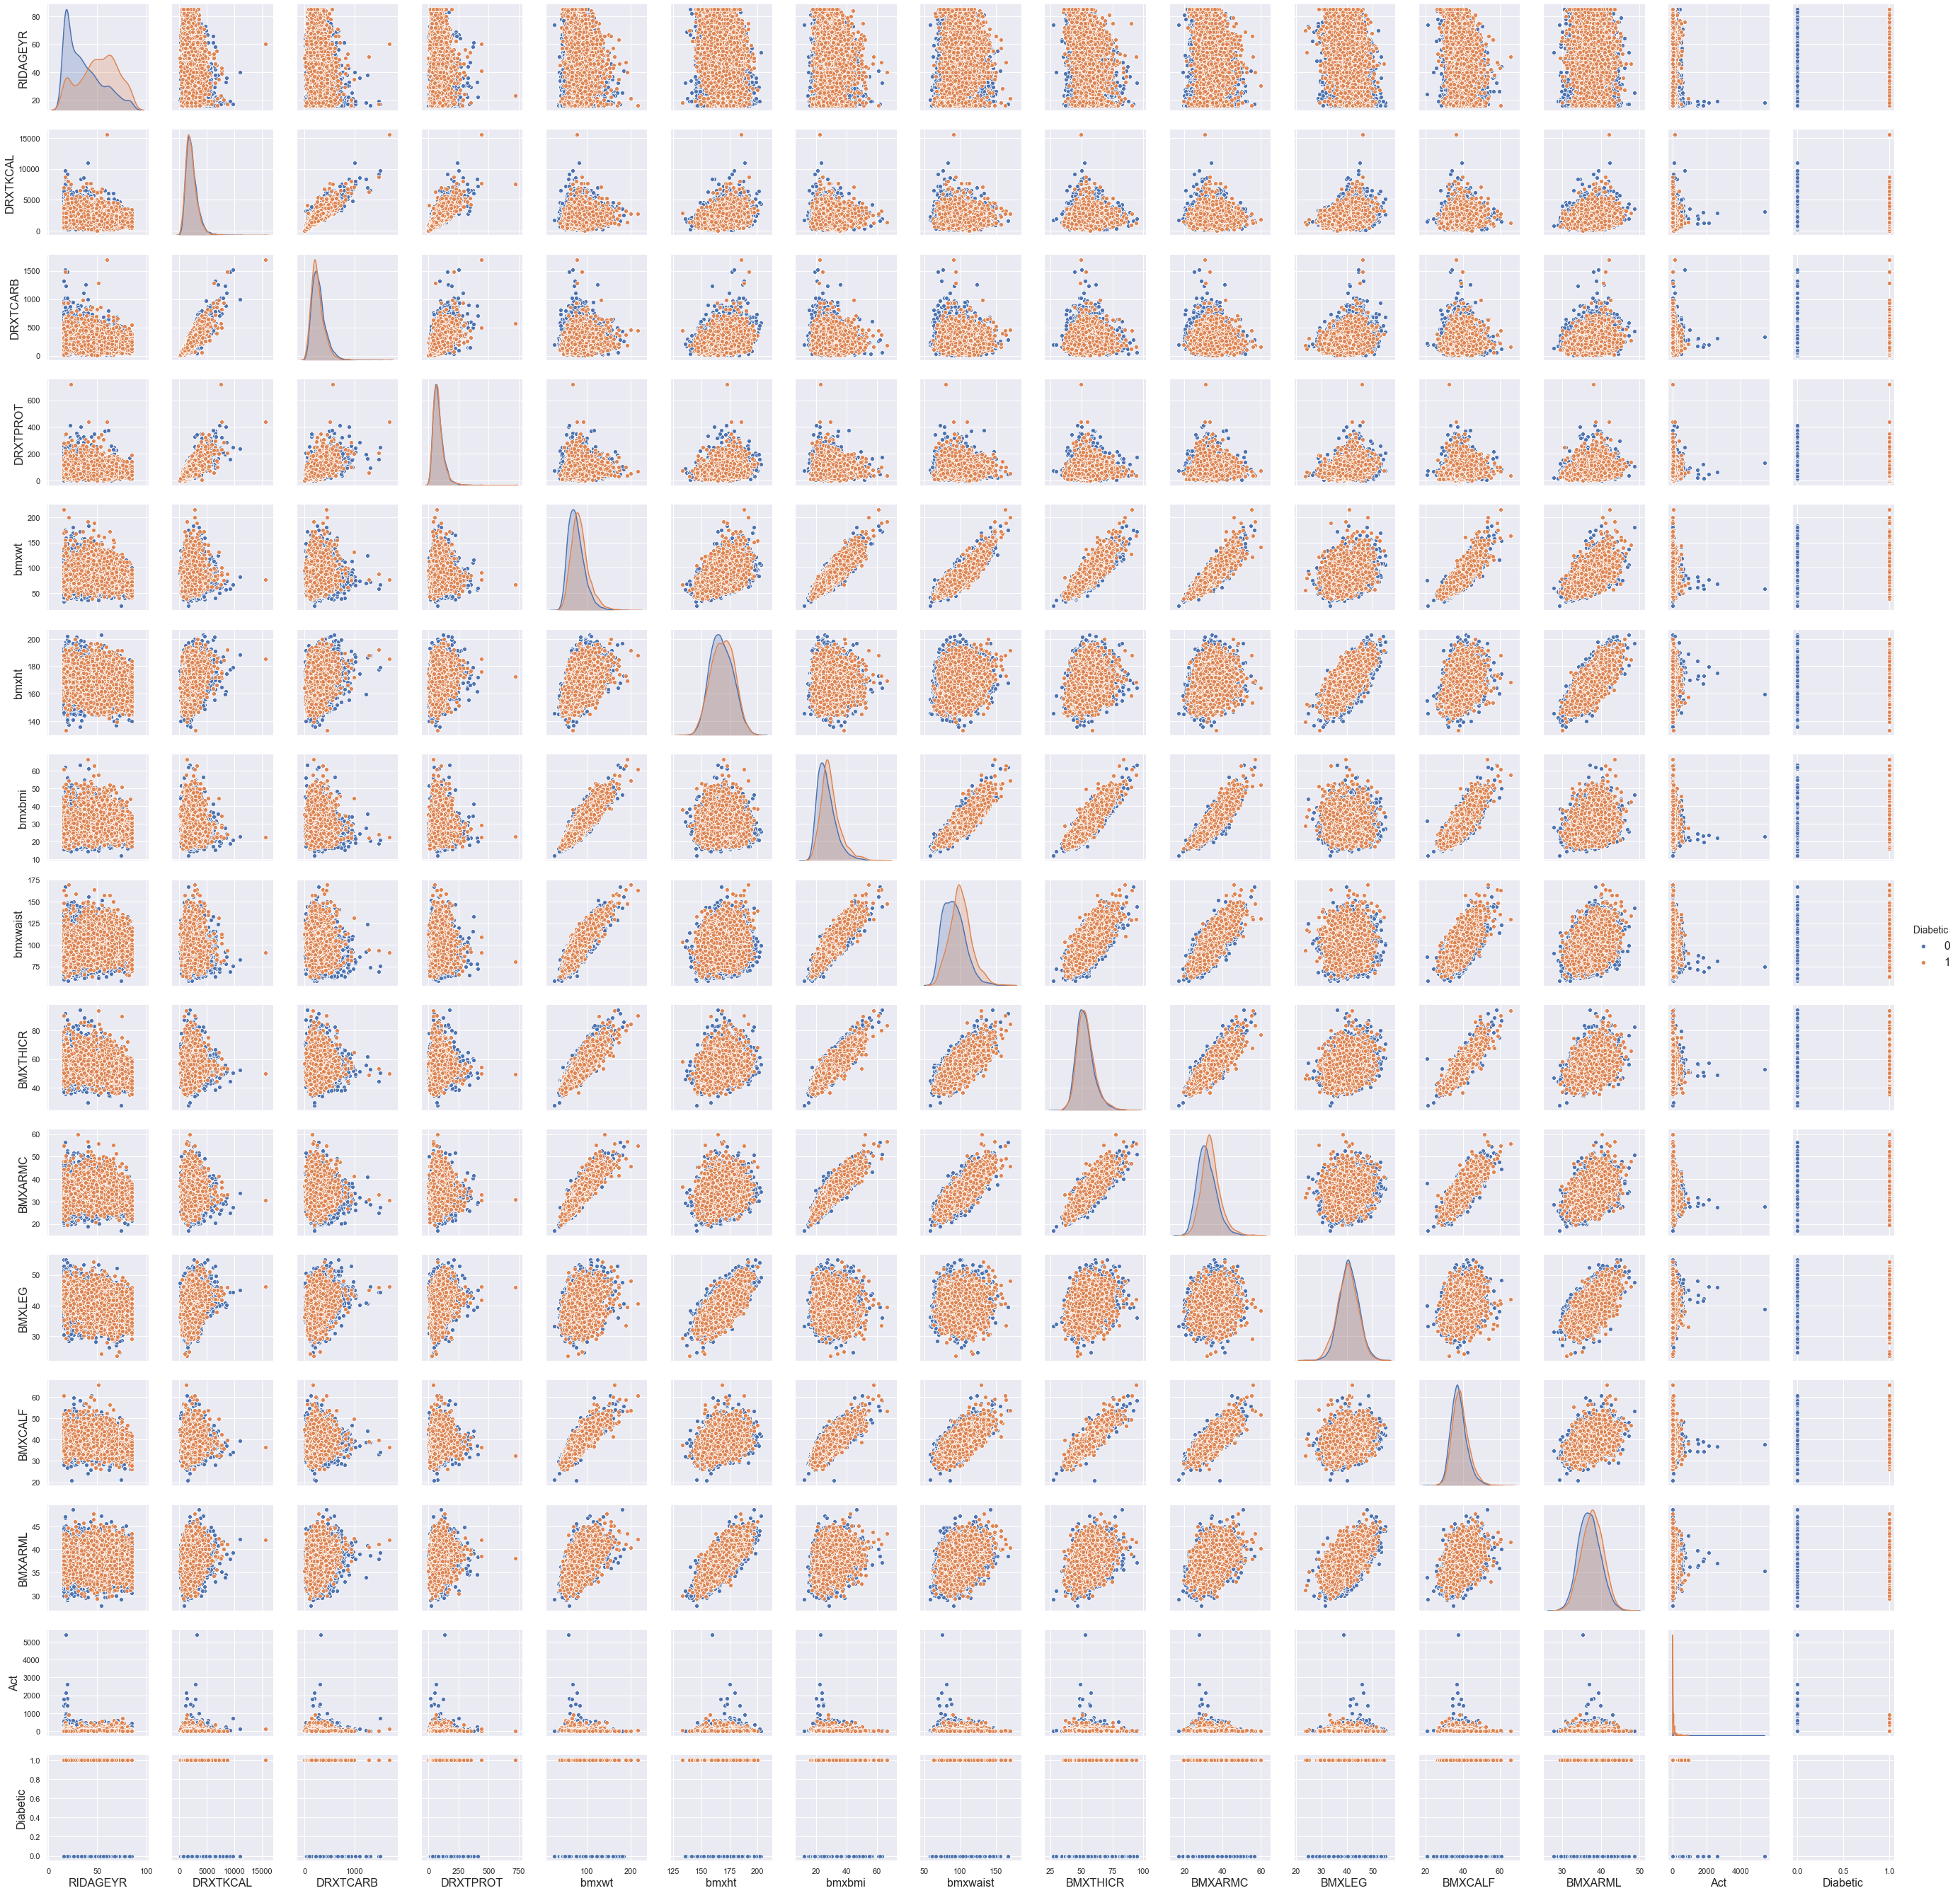

In [468]:
sns_plot = sns.pairplot(df_diab4[feature_cont3+['Diabetic']], hue='Diabetic', size=2.5)
#sns_plot.savefig("output.png")

In [106]:
X_cat.to_pickle('X.pickle')
y.to_pickle('Y.pickle')

In [395]:
#LR(df_diab4,feature_cat+feature_cont3,'DXDTOFAT')
#RF(df_diab4,FS3,target)

### - Logistic regression:
- The confusion matrix and classification report metrics are printed showing the performance of the model.

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
LR_model = LogisticRegression(C=0.01,class_weight='balanced').fit(X_train,y_train)

yhat = LR_model.predict(X_test)

print (classification_report(y_test,yhat ))
print(confusion_matrix(y_test, yhat, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.85      0.65      0.74      1157
           1       0.46      0.72      0.56       468

    accuracy                           0.67      1625
   macro avg       0.65      0.69      0.65      1625
weighted avg       0.74      0.67      0.69      1625

[[752 405]
 [129 339]]


### -Random Forest:

In [141]:
from sklearn.ensemble import RandomForestClassifier
RF_model =RandomForestClassifier(max_depth=10, random_state=0,class_weight='balanced').fit(X_train,y_train)

yhat = RF_model.predict(X_test)

print (classification_report(y_test,yhat ))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1157
           1       0.52      0.56      0.54       468

    accuracy                           0.72      1625
   macro avg       0.67      0.68      0.67      1625
weighted avg       0.73      0.72      0.73      1625

[[914 243]
 [204 264]]


In [142]:
from sklearn.neighbors import KNeighborsClassifier
Knn_model= KNeighborsClassifier(n_neighbors=10, weights='uniform').fit(X_train,y_train)
yhat = Knn_model.predict(X_test)

print (classification_report(y_test,yhat ))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1157
           1       0.53      0.24      0.33       468

    accuracy                           0.72      1625
   macro avg       0.64      0.58      0.58      1625
weighted avg       0.68      0.72      0.68      1625

[[1055  102]
 [ 355  113]]


In [459]:
logReg_coeff = pd.DataFrame({'feature_name': feat_all, 'model_coefficient': abs(LR_model.coef_.transpose().flatten())})
logReg_coeff = logReg_coeff.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff.head(20)
logReg_coeff_bottom = logReg_coeff.tail(20)
# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="Blues_d")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="GnBu_d")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
plt.savefig('figure_4.png')

ValueError: arrays must all be same length

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.760
Random Forest: ROC AUC=0.757
Knn: ROC AUC=0.708


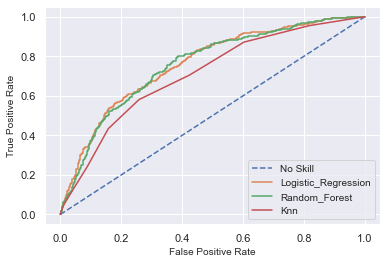

In [143]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = LR_model.predict_proba(X_test)
rf_probs= RF_model.predict_proba(X_test)
Knn_probs= Knn_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
rf_probs = rf_probs[:, 1]
Knn_probs = Knn_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
Knn_auc = roc_auc_score(y_test, Knn_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
print('Knn: ROC AUC=%.3f' % (Knn_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
Knn_fpr, Knn_tpr, _ = roc_curve(y_test, Knn_probs)


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='', label='Logistic_Regression')
plt.plot(rf_fpr, rf_tpr, marker='', label='Random_Forest')
plt.plot(Knn_fpr, Knn_tpr, marker='', label='Knn')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot

plt.show()

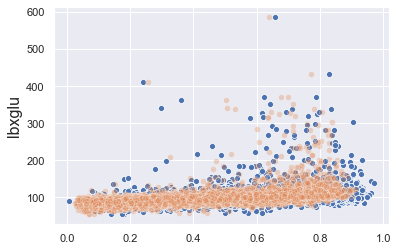

In [59]:
lr_probs = LR_model.predict_proba(X_cat)
rf_probs = RF_model.predict_proba(X_cat)

lr_diab_prob=lr_probs[:,1]
rf_diab_prob=rf_probs[:,1]

#ax=sns.distplot(prob)
#sns.distplot(df_diab3.lbxglu/100 , color="olive",)
ax=sns.scatterplot(x=lr_diab_prob,y=df_diab4.lbxglu,alpha=1)
ax=sns.scatterplot(x=rf_diab_prob,y=df_diab4.lbxglu,alpha=0.3)

#sns.scatterplot(x=rf_diab_prob,y=df_diab4.Diabetic)

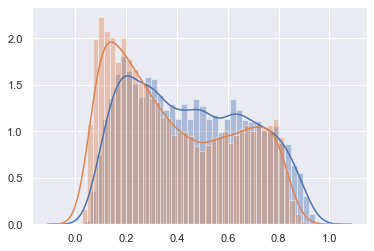

In [144]:
ax2=sns.distplot(lr_diab_prob,bins=40)
ax2=sns.distplot(rf_diab_prob,bins=40)

In [104]:
hist_values = np.histogram(lr_diab_prob,bins=40)
hist_values

(array([ 10,  69, 106, 126, 158, 200, 239, 235, 260, 241, 225, 255, 230,
        236, 267, 224, 211, 207, 222, 227, 208, 213, 208, 202, 199, 192,
        184, 180, 198, 211, 170, 182, 152, 138, 109,  86,  53,  27,  14,
          8]),
 array([0.07106225, 0.09277079, 0.11447934, 0.13618788, 0.15789642,
        0.17960496, 0.20131351, 0.22302205, 0.24473059, 0.26643913,
        0.28814768, 0.30985622, 0.33156476, 0.3532733 , 0.37498185,
        0.39669039, 0.41839893, 0.44010747, 0.46181602, 0.48352456,
        0.5052331 , 0.52694164, 0.54865019, 0.57035873, 0.59206727,
        0.61377581, 0.63548436, 0.6571929 , 0.67890144, 0.70060998,
        0.72231853, 0.74402707, 0.76573561, 0.78744415, 0.8091527 ,
        0.83086124, 0.85256978, 0.87427832, 0.89598687, 0.91769541,
        0.93940395]))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.759


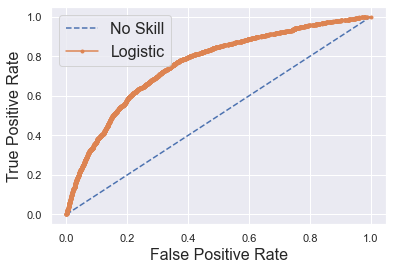

In [427]:
ns_probs = [0 for _ in range(len(y_train))]
lr_probs = LR_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_train, ns_probs)
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [407]:
pip install shap

     |████████████████████████████████| 276kB 2.2MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-macosx_10_9_x86_64.whl size=307123 sha256=6585f2c7b5f68ccdf0fd833a8526e5693c51feff540bd442c631320629db5220
  Stored in directory: /Users/Ali/Library/Caches/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
Note: you may need to restart the kernel to use updated packages.


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


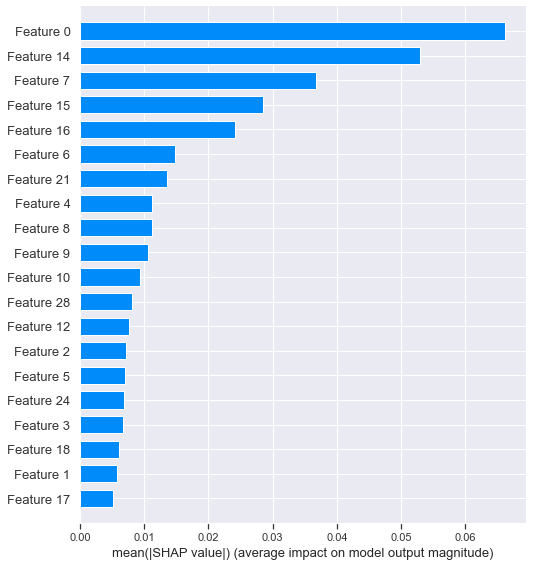

In [145]:
import shap
shap_values = shap.TreeExplainer(RF_model).shap_values(X_train)
shap.summary_plot(shap_values[0], X_train, plot_type="bar")

In [146]:
X_cat0.columns

Index(['RIDAGEYR', 'DRXTKCAL', 'DRXTCARB', 'DRXTPROT', 'bmxwt', 'bmxht',
       'bmxbmi', 'bmxwaist', 'BMXTHICR', 'BMXARMC', 'BMXLEG', 'BMXCALF',
       'BMXARML', 'Act', 'fat_ratio', 'WCI', 'RIAGENDR_2', 'RACETH_2',
       'RACETH_3', 'RACETH_4', 'Fa_hist_1', 'BPQ020_2.0', 'SMQ020_2.0',
       'Educ_1', 'HHS_1', 'gen_act_1', 'Inact_1', 'PAQ540_2.0', 'PAQ540_3.0',
       'PAQ500_2.0', 'PAQ500_3.0', 'PAQ520_2.0', 'PAQ520_3.0'],
      dtype='object')

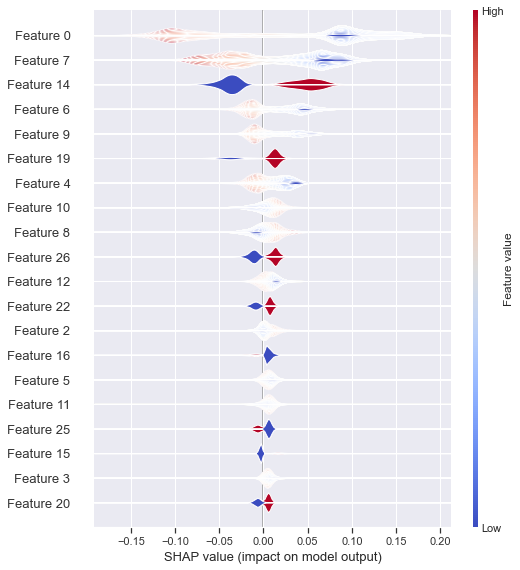

In [466]:
shap.summary_plot(shap_values[0], X_train, plot_type="layered_violin")

Logistic:
	Brier: 0.202
	Precision: 0.468
	Recall: 0.708
	F1: 0.564

Naive Bayes:
	Brier: 0.260
	Precision: 0.448
	Recall: 0.646
	F1: 0.529

Naive Bayes + Isotonic:
	Brier: 0.180
	Precision: 0.534
	Recall: 0.252
	F1: 0.343

Naive Bayes + Sigmoid:
	Brier: 0.181
	Precision: 0.512
	Recall: 0.374
	F1: 0.432

Logistic:
	Brier: 0.202
	Precision: 0.468
	Recall: 0.708
	F1: 0.564

RF:
	Brier: 0.181
	Precision: 0.511
	Recall: 0.596
	F1: 0.550

RF + Isotonic:
	Brier: 0.169
	Precision: 0.597
	Recall: 0.410
	F1: 0.486

RF + Sigmoid:
	Brier: 0.168
	Precision: 0.597
	Recall: 0.404
	F1: 0.482



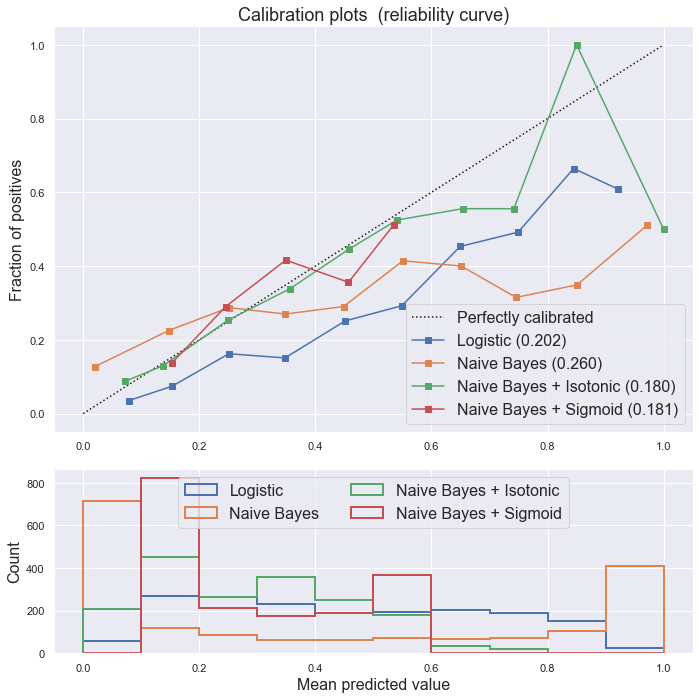

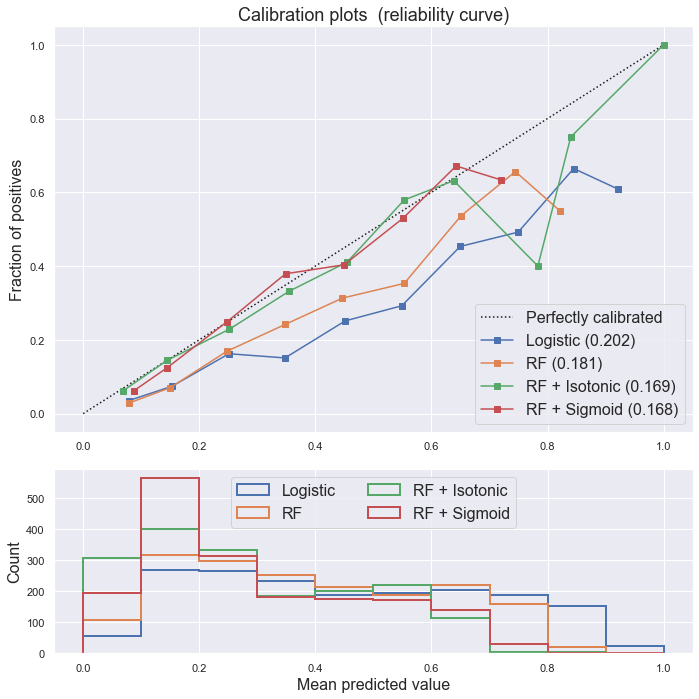

In [62]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.,class_weight='balanced')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
#plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)

plot_calibration_curve(RandomForestClassifier(max_depth=10, random_state=0,class_weight='balanced'), "RF", 2)


plt.show()

In [56]:
import pickle
pickle.dump(RF_model, open("RF_model1.pkl","wb"))

In [57]:
with open('RF_model1.pkl', 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [99]:
Pickled_LR_Model.predict_proba(dff)[:,1]*100

array([70.70961531])

In [60]:
X_test.head()

RIDAGEYR  bmxbmi  bmxwaist  RIAGENDR_2
6907         52   23.58      84.3           0
12498        47   29.00     100.5           1
19028        43   30.33      99.9           0
3942         60   25.96      93.5           0
28167        22   24.03      82.0           0

In [98]:
#data = [['RIDAGEYR', 20,1], ['bmxbmi', 45,1], ['bmxwaist', 85,1],['RIAGENDR_2', 1,1]] 
data = [[80, 40,120,1]] 

# Create the pandas DataFrame 
dff = pd.DataFrame(data, columns = ['RIDAGEYR', 'bmxbmi','bmxwaist','RIAGENDR_2'])
dff

RIDAGEYR  bmxbmi  bmxwaist  RIAGENDR_2
0        80      40       120           1

### -SVM:

In [190]:
from sklearn.svm import SVC
SVC_model =SVC(kernel='linear',class_weight='balanced').fit(X_train,y_train)

yhat = SVC_model.predict(X_test)

print (classification_report(y_test,yhat))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.86      0.64      0.74       978
           1       0.46      0.75      0.57       399

    accuracy                           0.67      1377
   macro avg       0.66      0.70      0.65      1377
weighted avg       0.75      0.67      0.69      1377

[[629 349]
 [101 298]]


### -Naive bayes:

In [557]:
from sklearn.naive_bayes import GaussianNB
NB_model =GaussianNB().fit(X_train,y_train)

yhat = NB_model.predict(X_test)

print (classification_report(y_test,yhat))
print(confusion_matrix(y_test, yhat, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       865
           1       0.48      0.42      0.45       429

    accuracy                           0.66      1294
   macro avg       0.60      0.60      0.60      1294
weighted avg       0.65      0.66      0.65      1294

[[669 196]
 [249 180]]


In [264]:
pip install flask


Note: you may need to restart the kernel to use updated packages.


In [8]:
import streamlit as st
st.title('Uber pickups in NYC')
dfToShow= df_diab.sort_values("RIDAGEYR", ascending=False)
#st.bar_chart(dfToShow)

In [9]:
dfToShow

lbxglu  RIAGENDR  RIDAGEYR  RACETH  DXDTOFAT  DXDTOLE  DRXTKCAL  \
9532     92.3         1        85       1   23469.5  54778.3    1099.0   
12399   103.1         1        85       2   12898.9  49709.3    1533.0   
6488      NaN         2        85       3   15353.7  28586.5    1034.0   
19560    96.1         2        85       1   19485.9  31493.8    1514.0   
2433      NaN         2        85       1   12765.1  28831.5    1383.9   
...       ...       ...       ...     ...       ...      ...       ...   
21513     NaN         1         8       4   30451.9  36619.9    2620.0   
26251     NaN         2         8       1    8062.4  24665.5    2238.0   
18382     NaN         2         8       1    5045.2  16442.8       NaN   
8600      NaN         2         8       3    6976.8  16003.5    1429.0   
11557     NaN         1         8       3    5125.1  19514.8    2450.0   

       DRXTCARB  DRXTPROT  DRXTTFAT  ...  PAQ480  PAD200  PAD320  PAD440  \
9532     124.66     25.98     31.45  ...     5.0     2.0     1.0     2.0   
12399    251.34     58.53     34.64  ...     2.0     2.0     2.0     2.0   
6488     150.27     31.53     40.35  ...     0.0     3.0     3.0     3.0   
19560    209.30     48.38     57.08  ...     NaN     3.0     3.0     3.0   
2433     193.06     39.57     55.37  ...     5.0     2.0     2.0     2.0   
...         ...       ...       ...  ...     ...     ...     ...     ...   
21513    376.71     72.50     95.08  ...     NaN     NaN     NaN     NaN   
26251    322.27     67.65     77.91  ...     NaN     NaN     NaN     NaN   
18382       NaN       NaN       NaN  ...     NaN     NaN     NaN     NaN   
8600     198.30     42.17     54.95  ...     NaN     NaN     NaN     NaN   
11557    312.59     97.02     92.04  ...     NaN     NaN     NaN     NaN   

       SMQ020  SMQ040  DMDEDUC2  DMDHHSIZ  INDFMINC  INDFMPIR  
9532      1.0     3.0       4.0         2      10.0      5.00  
12399     2.0     NaN       1.0         1       3.0      1.41  
6488      1.0     1.0       2.0         2       3.0      0.86  
19560     2.0     NaN       3.0         1       3.0      1.13  
2433      2.0     NaN       1.0         1      13.0       NaN  
...       ...     ...       ...       ...       ...       ...  
21513     NaN     NaN       1.0         6      13.0       NaN  
26251     NaN     NaN       1.0         6      11.0      4.10  
18382     NaN     NaN       1.0         3       3.0      0.77  
8600      NaN     NaN       1.0         4      11.0      4.14  
11557     NaN     NaN       1.0         5       6.0      1.18  

[29026 rows x 41 columns]

In [24]:
import sys
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import altair as alt
import streamlit as st

st.title('Uber pickups in NYC')
#st.bar_chart(dfToShow)

if sys.version_info[0] < 3:
    reload(sys) # noqa: F821 pylint:disable=undefined-variable
    sys.setdefaultencoding("utf-8")
    
#@st.cache
def get_data():

    address='DataSet/NHANES 1999-2006.xlsx'
    df=pd.read_excel(address)
    feature_dem=['lbxglu','RIAGENDR','RIDAGEYR','RACETH','DXDTOFAT','DXDTOLE']
    feature_cal=['DRXTKCAL','DRXTCARB','DRXTPROT','DRXTTFAT','DRXTSFAT','DXXTRFAT']
    feature_BM=['bmxwt','bmxht','bmxbmi','bmxwaist','BMXTHICR','BMXARMC','BMXLEG','BMXCALF','BMXARML']
    feature_diab=['DIQ050','DIQ070','MCQ250A']
    feature_bp=['BPQ020']
    feature_act=['PAD020','PAD080','PAQ100','PAD120','PAD160','PAQ180','PAQ480','PAD200','PAD320','PAD440']
    feature_sm=['SMQ020','SMQ040']
    feature_ed=['DMDEDUC2','DMDHHSIZ','INDFMINC','INDFMPIR']

    feature_tot=feature_dem+ feature_cal+feature_BM+feature_diab+feature_bp+feature_act+feature_sm+feature_ed

    df_diab=df[feature_tot].dropna()
    #AWS_BUCKET_URL = "https://streamlit-demo-data.s3-us-west-2.amazonaws.com"
    #df = pd.read_csv(AWS_BUCKET_URL + "/agri.csv.gz")
    return df_diab


df2 = get_data()


# Education = st.multiselect(
#     "Choose Education", list(df.DMDEDUC2.unique()), [0]
# )
# data = df.loc[Education]
# st.write(data)

In [26]:
list(df2.DMDEDUC2.unique())

[4.0, 2.0, 1.0, 5.0, 3.0]